# Image Manipulation

When working with photographic images, a source image may require some amount of manipulation or processing for specific use in a piece of teaching material.

In this notebook, we explore how source images can be manipulated in a reproducible way.

In [21]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## `skimage`

The `skimage` (*scikit-image*) Python package provides a wide range of image processing tools.

In [4]:
import skimage

Colour wheels are often used to represent the relationship between different colours in "color space". For example, the following colour wheel is taken fron an OU / OpenLearn art history unit ([*Making sense of art history*](http://www.open.edu/openlearn/history-the-arts/making-sense-art-history/content-section-5.3)):

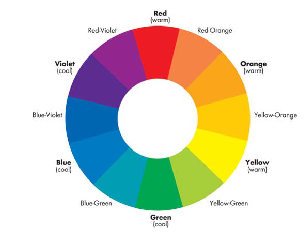

In [25]:
from skimage.io import imread
import matplotlib.pyplot as plt

url_color_wheel='http://www.open.edu/openlearn/ocw/pluginfile.php/59985/mod_oucontent/oucontent/382/39c469f3/d100a96b/y180_2_001i.jpg'
color_wheel = imread(url_color_wheel)
plt.imshow(color_wheel)
plt.axis('off');

The first thing to notice about this colour wheel is that is provided as an *image* in its own right. So might we be able to analyse / process that image in a useful way?

How about if we try to filter the image to only show colours that are blue, or at least, blue-ish?

In [ ]:
from skimage import io, color, exposure, img_as_float
import matplotlib.pyplot as plt

#https://stackoverflow.com/a/21661395/454773
#can we generalise this to easily specify eg red, green blue, or other point on colour wheel?
#so for example, we might have a slider along ROYGBIV to let us select a hue
#and maybe a slider to select the "width"?
#(Do ipywidgets support range sliders?)
def get_blues(image):
    ''' Function to filter an image to only show blue / blue-ish components. '''
    
    blue_lab = color.rgb2lab([[[0, 0, 1.]]])
    light_blue_lab = color.rgb2lab([[[0, 1, 1.]]])
    red_lab = color.rgb2lab([[[1, 0, 0.]]])
    image_lab = color.rgb2lab(image)

    distance_blue = color.deltaE_cmc(blue_lab, image_lab, kL=0.5, kC=0.5)
    distance_light_blue = color.deltaE_cmc(light_blue_lab, image_lab, kL=0.5, kC=0.5)
    distance_red = color.deltaE_cmc(red_lab, image_lab, kL=0.5, kC=0.5)
    distance = distance_blue + distance_light_blue - distance_red
    distance = exposure.rescale_intensity(distance)

    image_blue = image.copy()
    image_blue[distance > 0.3] = 0

    image_blue = image.copy()
    image_blue[distance > 0.3] = 0


    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
    ax0.imshow(image)
    ax1.imshow(distance, cmap='gray')
    ax2.imshow(image_blue)
    plt.show()
    

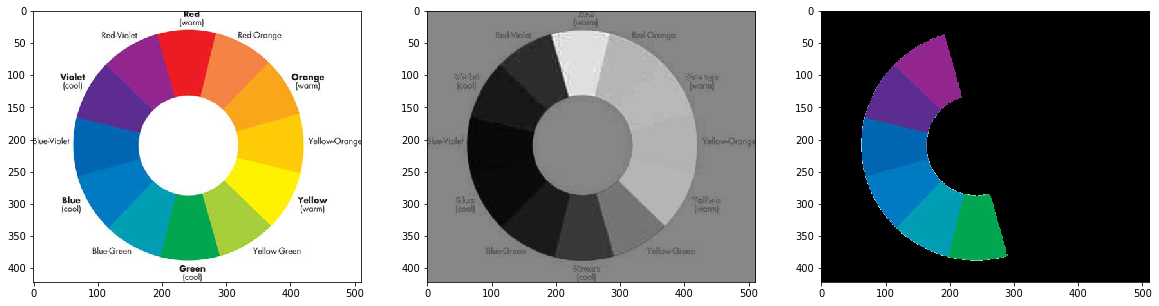

In [27]:
get_blues(color_wheel)

If we create our own colour wheel as a computational object, then we might be able to do things with it as part of the learning design.

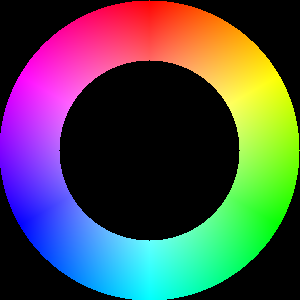

In [16]:
#If we're doing a reproducible thing, then let's create a color wheel...
#https://rosettacode.org/wiki/Color_wheel
from PIL import Image
import colorsys
import math


def createColourWheel(size=(300,300), angle=0 ):
    ''' Create a colour wheel. '''
    im = Image.new("RGB", size)
    radius = min(im.size)/2.0
    centre = im.size[0]/2, im.size[1]/2
    pix = im.load()

    for x in range(im.width):
        for y in range(im.height):
            rx = x - centre[0]
            ry = y - centre[1]
            s = ((x - centre[0])**2.0 + (y - centre[1])**2.0)**0.5 / radius
            if s <= 1.0 and s>0.6:
                h = ((math.atan2(ry, rx) / math.pi) + 1.0) / 2.0
                rgb = colorsys.hsv_to_rgb(h, s, 1.0)
                pix[x,y] = tuple([int(round(c*255.0)) for c in rgb])

    #We can rotate and resize the PIL image directly
    im = im.rotate(angle, expand=1 )
    
    #We can also do thngs like resize the image
    #im = im.resize(size)
    
    return im

im = createColourWheel(angle=-90)
im
#The image looks a bit ragged to me? We maybe need to up the size?

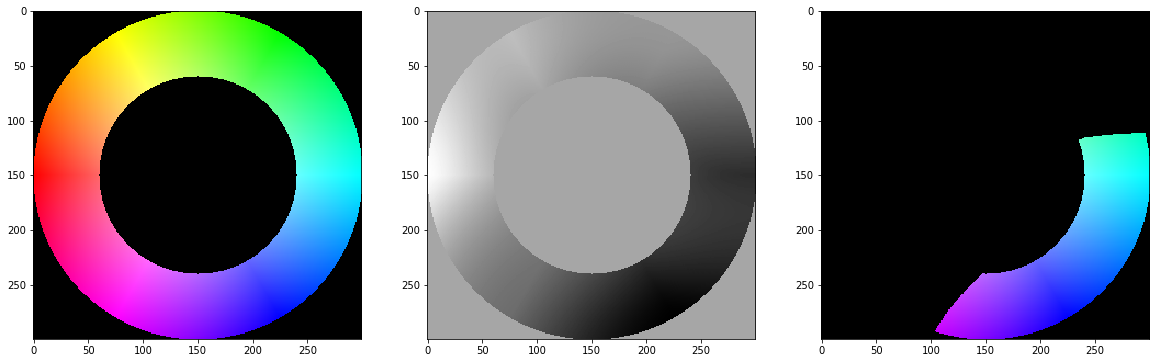

In [56]:
import numpy
get_blues(numpy.array(im))

The notebooks provide us with a computational medium that allows us analyse images programmatically. So can we start to analyse images in a way that contributes to the learning objectives of a course?

For example, the [OpenLearn unit](http://www.open.edu/openlearn/history-the-arts/making-sense-art-history/content-section-5.5) asks *"Are the colours largely bright or dull?"* in some example pictures. If "bright" and "dull" are physically meaningful terms, can we measure these dimensions, and create a simple tool that lets students look at arbitrary pictures and check their interpretation of them against the machine's interpretation, accroding to a particular measure?

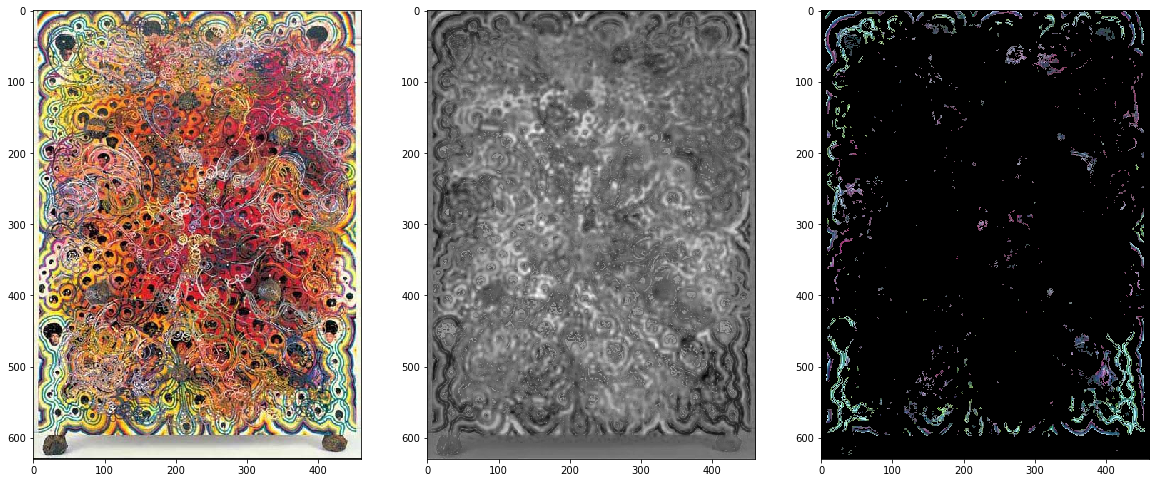

In [73]:
url='http://www.open.edu/openlearn/ocw/pluginfile.php/59985/mod_oucontent/oucontent/382/39c469f3/0451e123/plate10.jpg'
image = imread(url)
get_blues(image)

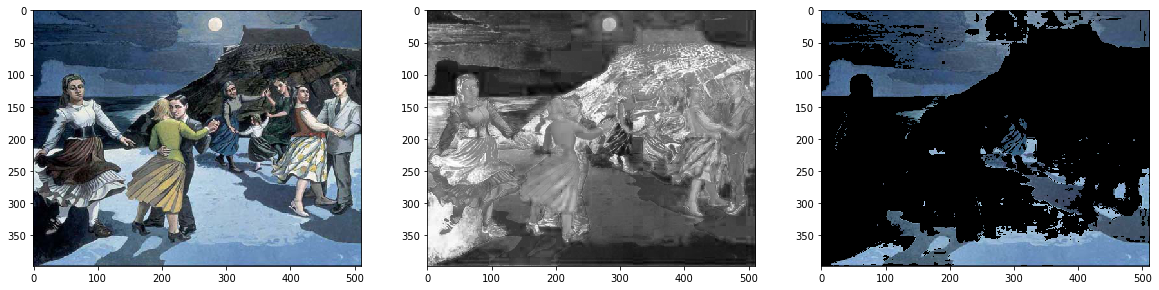

In [89]:
url='http://www.open.edu/openlearn/ocw/pluginfile.php/59985/mod_oucontent/oucontent/382/39c469f3/54a0d6e0/plate14.small.jpg'
image = imread(url)
get_blues(image)

## Finding Dominant Colour

Perhaps more useful would be something that lets us extract the dominant colour from an image?

A naive approach would be to simply calculate the "average" pixel colour value, but this loses the sense of the actual colours contained in a picture. Instead, we can use a clustering technique to try to identify colour values that appear most frequently in a picture.

In [22]:
##https://code.likeagirl.io/finding-dominant-colour-on-an-image-b4e075f98097
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

def plot_colors2(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar


#Use kmeans clustering to find dominant colour values
from IPython.display import display, Image
from skimage.io import imread
def palettiser1(fp, k=3):
    if fp.startswith('http'):
        image = imread(fp)
    else:
        image = cv2.imread(fp)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    img = image.reshape((image.shape[0] * image.shape[1],3)) #represent as row*column,channel number
    clt = KMeans(n_clusters=k) #cluster number
    clt.fit(img)

    hist = find_histogram(clt)
    bar = plot_colors2(hist, clt.cluster_centers_)

    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    
    plt.imshow(image)

In [17]:
%%capture
url='http://www.open.edu/openlearn/ocw/pluginfile.php/59985/mod_oucontent/oucontent/382/39c469f3/0451e123/plate10.jpg'
#-nc is no-clobber: don't get it again if we already have it
!wget -nc -P images/ $url

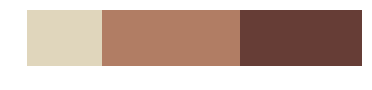

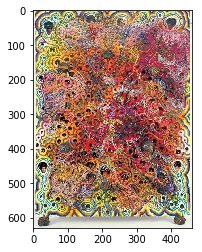

In [20]:
palettiser1('images/plate10.jpg')

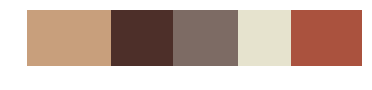

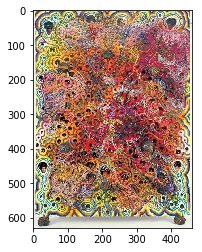

In [23]:
#Generate a palette containing a specified number of dominant colours
palettiser1(url, 5)

In [30]:
%%capture
#colorthief - https://github.com/fengsp/color-thief-py
#Grabs the dominant color or a representative color palette from an image. 
try:
    import colorthief
except:
    !pip install colorthief

In [31]:
import colorthief

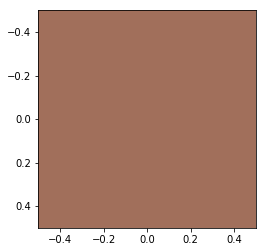

In [32]:
from colorthief import ColorThief

color_thief = ColorThief('images/plate10.jpg')

#Dominant colour
c=color_thief.get_color(quality=1)
plt.imshow([[tuple(col/255 for col in c)]]);

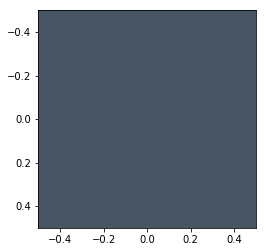

In [43]:
color_thief = ColorThief('images/plate14.small.jpg')

#Dominant colour
c=color_thief.get_color(quality=1)
plt.imshow([[tuple(col/255 for col in c)]]);

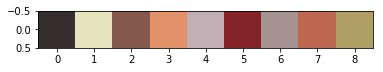

In [33]:
#palette
c2 = color_thief.get_palette(color_count=10)
plt.imshow([[tuple(col/255 for col in c) for c in c2]])

In [34]:
%%capture
url='http://www.open.edu/openlearn/ocw/pluginfile.php/59985/mod_oucontent/oucontent/382/39c469f3/54a0d6e0/plate14.small.jpg'
!wget -nc -P images/ $url

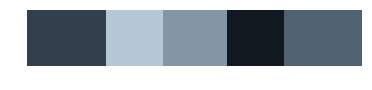

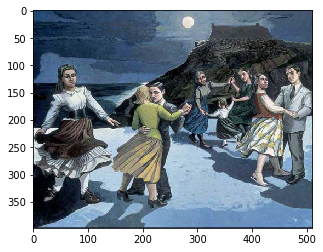

In [35]:
palettiser1('images/plate14.small.jpg', 5)

In [38]:
def palettiser2(fp, p=6):
    color_thief = ColorThief(fp)
    
    c2 = color_thief.get_palette(color_count=p)
    plt.imshow([[tuple(col/255 for col in c) for c in c2]])
    plt.show()
    
    image = cv2.imread(fp)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image);

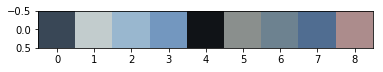

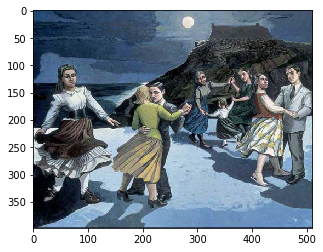

In [41]:
palettiser2('images/plate14.small.jpg', 10)

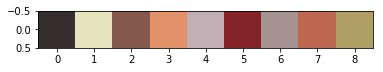

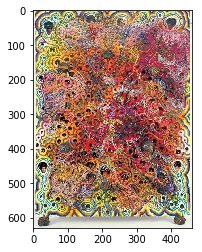

In [42]:
palettiser2('images/plate10.jpg', 10)

In [ ]:
#This https://zeevgilovitz.com/detecting-dominant-colours-in-python may be handy
#as an example of how to add a colour palette band to the side of the image?

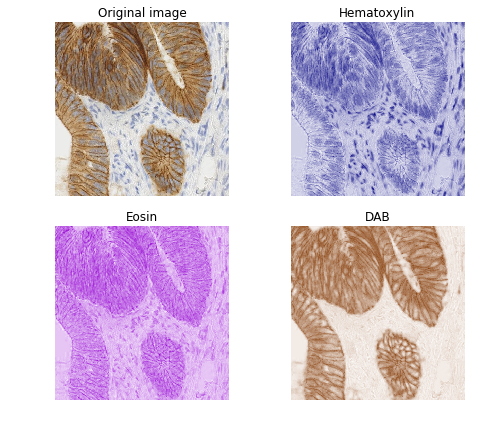

In [3]:
#Example from http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html

from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap

# Create an artificial color close to the orginal one
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                             'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet',
                                               'white'])

ihc_rgb = data.immunohistochemistry()
ihc_hed = rgb2hed(ihc_rgb)

fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original image")

ax[1].imshow(ihc_hed[:, :, 0], cmap=cmap_hema)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_hed[:, :, 1], cmap=cmap_eosin)
ax[2].set_title("Eosin")

ax[3].imshow(ihc_hed[:, :, 2], cmap=cmap_dab)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

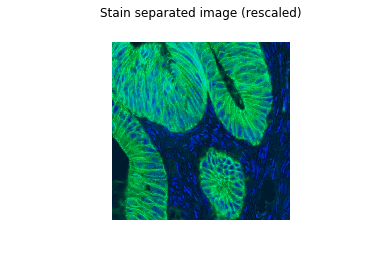

In [4]:
import numpy as np
from skimage.exposure import rescale_intensity

# Rescale hematoxylin and DAB signals and give them a fluorescence look
h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1))
d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1))
zdh = np.dstack((np.zeros_like(h), d, h))

fig = plt.figure()
axis = plt.subplot(1, 1, 1, sharex=ax[0], sharey=ax[0])
axis.imshow(zdh)
axis.set_title("Stain separated image (rescaled)")
axis.axis('off')
plt.show()

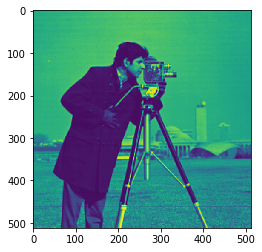

In [36]:
import numpy as np

from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt

image = camera()
plt.imshow(image)

In [24]:
#What is the size of the image in x/y pixels?
image.shape

(512, 512)

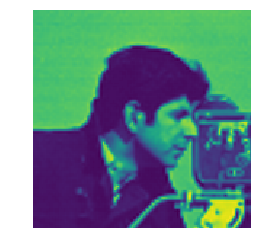

In [35]:
#We can zoom in to a part of the image
cropped_image = image[50:200, 150:300]
plt.axis('off')
plt.imshow(cropped_image);

A wide range of filtering opportunities exist. For example, edge detection:

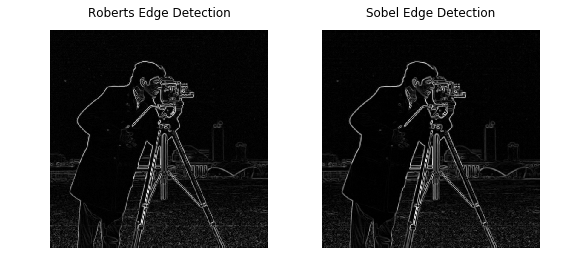

In [6]:
#http://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html

edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Other sets of image processing examples to try:
#https://auth0.com/blog/image-processing-in-python-with-pillow/

## `OpenCV`

In [8]:
import cv2

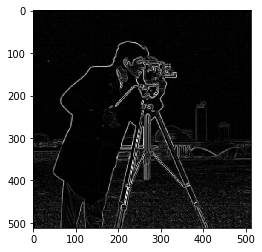

In [22]:
ddepth = cv2.CV_64F  # 64-bit float output
#Do filter in x and y directions
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1)
sobel = cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2.0), 1.0, cv2.pow(sobely, 2.0), 1.0, 0.0))

plt.imshow(sobel, cmap='gray');

In [190]:
#https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/
import cv2
def colHistRGB(image):
    # grab the image channels, initialize the tuple of colors,
    # the figure and the flattened feature vector
    chans = cv2.split(image)
    #is this right? Opencv seems to mess with RGB/BGR and I have no idea what colour is what...
    colors = ("b", "g", "r")
    plt.figure()
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    features = []

    #What do the bins represent? Value of colour channel?
    # loop over the image channels
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)

        # plot the histogram
        plt.plot(hist, color = color)
        plt.xlim([0, 256])     

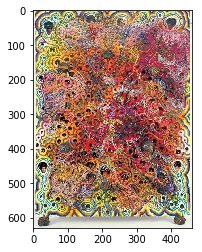

In [213]:
url='http://www.open.edu/openlearn/ocw/pluginfile.php/59985/mod_oucontent/oucontent/382/39c469f3/0451e123/plate10.jpg'
image = imread(url)
plt.imshow(image);

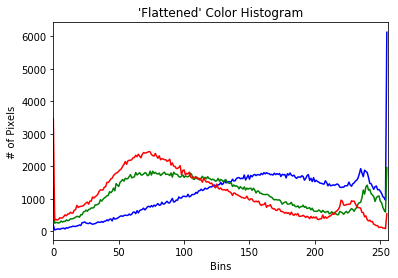

In [214]:
colHistRGB(image)   

In [215]:
#problem with the above is you don't know whether eg you have high R, low G, low B, or high R, G, B at one pixel?
#would map on gray level report that? So high average RGB is bright?

(0, 256)

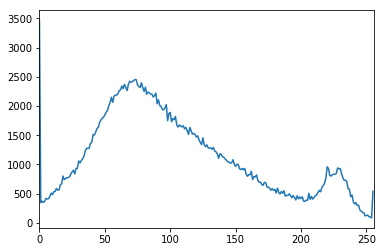

In [216]:
from skimage.io import imsave

imsave('images/testout.png',image)
#COLOR_BGR2GRAY COLOR_RGBA2BGRA
img = cv2.imread('images/testout.png',cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)
plt.xlim([0, 256])   

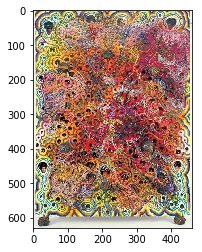

In [217]:
#The plt/numpy(?) uses RGB array whereas opencv uses BGR array
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

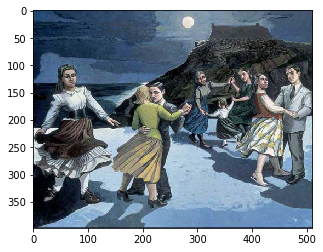

In [219]:
url='http://www.open.edu/openlearn/ocw/pluginfile.php/59985/mod_oucontent/oucontent/382/39c469f3/54a0d6e0/plate14.small.jpg'
image = imread(url)

plt.imshow(image)   

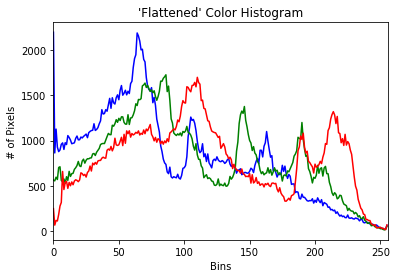

In [220]:
colHistRGB(image) 

(0, 256)

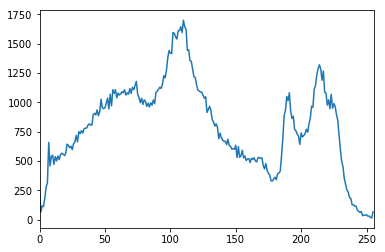

In [227]:
imsave('images/testout.png',image)
img = cv2.imread('images/testout.png',cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)
plt.xlim([0, 256])   

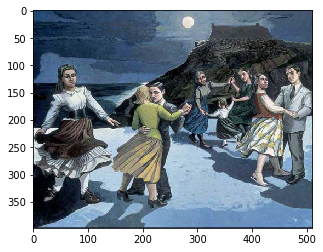

In [224]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))